In [1]:
import numpy as np
from obspy.geodetics.base import gps2dist_azimuth, kilometer2degrees
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import os

In [2]:
path = '/Users/sydneydybing/SW4/strain/experiments/realistic_eq_sizes/'

In [3]:
# Maximum frequency you want to model
freqMax = 0.1 #Hz

# Event and Station locations

In [16]:
# Ruptures

rupt_params = np.load(path + 'rupture_params.npy')
print(rupt_params)

# 0. Mw
# 1. Length (km)
# 2. Average slip (m)
# 3. Rise time (s)

# Common hypocenter

hypocenter = [-117.6204, 35.7793, 7.5]

[[5.00000000e+00 3.38844156e+00 1.51356125e-02 3.35853594e-01]
 [6.00000000e+00 1.41253754e+01 1.20226443e-01 9.23953255e-01]
 [7.00000000e+00 5.88843655e+01 9.54992586e-01 2.54185048e+00]
 [8.00000000e+00 2.45470892e+02 7.58577575e+00 6.99278217e+00]]


In [17]:
files_list = os.listdir(path)
# print(files_list)

rupts_list = []
for file in files_list:
    if file[-4:] == 'rupt':
        rupts_list.append(file)

print(rupts_list)

['fq_M7.000000.rupt', 'fq_M8.000000.rupt', 'fq_M6.000000.rupt', 'fq_M5.000000.rupt']


In [30]:
# Synthetic station grid

left_edge = -118.5
right_edge = -116.75
top_edge = 36.5
bottom_edge = 35

art_sta_lons = np.arange(left_edge, right_edge + 0.1, 0.1)
art_sta_lats = np.arange(bottom_edge, top_edge + 0.1, 0.1)

print(art_sta_lons.shape)
print(art_sta_lats.shape)

print(art_sta_lons)
print(art_sta_lats)

extra_sta_lons = []
extra_sta_lats = []

for idx in range(len(art_sta_lons)):
    
    lon = art_sta_lons[idx]
    
    for lat in art_sta_lats:
        
        extra_sta_lons.append(lon)
        extra_sta_lats.append(lat)

(19,)
(17,)
[-118.5 -118.4 -118.3 -118.2 -118.1 -118.  -117.9 -117.8 -117.7 -117.6
 -117.5 -117.4 -117.3 -117.2 -117.1 -117.  -116.9 -116.8 -116.7]
[35.  35.1 35.2 35.3 35.4 35.5 35.6 35.7 35.8 35.9 36.  36.1 36.2 36.3
 36.4 36.5 36.6]


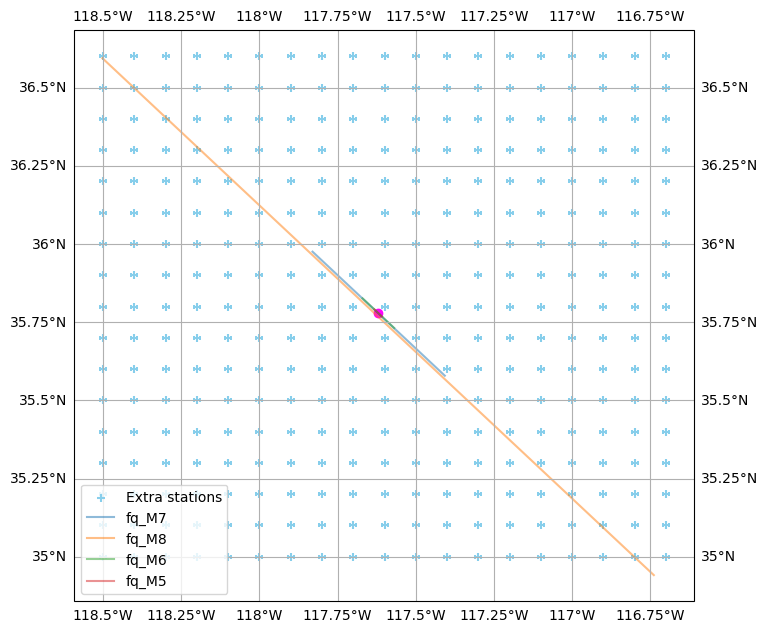

In [31]:
# Find fault extent for each one

fig = plt.figure(figsize = (8, 8))
ax = plt.axes(projection = ccrs.PlateCarree())

plt.scatter(hypocenter[0], hypocenter[1], color = 'magenta')
plt.scatter(extra_sta_lons, extra_sta_lats, marker = '+', color = 'skyblue', label = 'Extra stations')

for idx in range(len(rupts_list)):
    
    rupt = np.genfromtxt(path + rupts_list[idx])
    sf_lons = rupt[:,1]
    sf_lats = rupt[:,2]

    # Fault extent
    min_lon = min(sf_lons)
    max_lon = max(sf_lons)
    min_lat = min(sf_lats)
    max_lat = max(sf_lats)
    
    plt.plot([min_lon, max_lon], [max_lat, min_lat], color = 'C' + str(idx), label = rupts_list[idx][:5], alpha = 0.5)    
    
ax.legend(loc = 'lower left')
ax.coastlines()
gl = ax.gridlines(draw_labels = True)
Plotlims = ax.get_extent()
plt.show()

In [32]:
Plotlims

(-118.59235724999999, -116.60988775000011, 34.858218, 36.682942000000025)

# Velocity Model Stuff

In [36]:
# Load velocity model data. Doing simple block model for my project - no topography or pfile
vmod = pd.read_csv(path + 'mojave_header.mod', sep = '\t')
# vmod
thicknesses = vmod.Thickness.values
Vps = vmod.Vp.values
Vss = vmod.Vs.values
rhos = vmod.rho.values
Qps = vmod.Qp.values
Qss = vmod.Qs.values
# vmod

In [37]:
# Add column to vmod with Vp/Vs ratios

Vp_Vses = []

for i in range(len(vmod)):
    Vp = Vps[i]
    Vs = Vss[i]
    Vp_Vs = Vp/Vs
    Vp_Vses.append(Vp_Vs)

vmod['Vp/Vs'] = Vp_Vses
# vmod

In [38]:
# Assign some values from the velocity model for later
# We need Vs min for computing the desired resolution for the domain
# We need the max Vp/Vs ratio, becuase the number of points per wavelength you need for good resolution is higher for high Vp/Vs
vs_min = vmod['Vs'].min()
VpVs_max = vmod['Vp/Vs'].max()
ind = vmod.index[vmod['Vp/Vs'] == VpVs_max] # Find row with the max to get the Vp and Vs values
Vp_fromVpVsmax = vmod['Vp'][ind]
Vs_fromVpVsmax = vmod['Vs'][ind]
val = (Vs_fromVpVsmax**2) / (Vp_fromVpVsmax**2 - 2*Vs_fromVpVsmax**2)

val

0    0.081489
dtype: float64

If val here was <0.1 then we'd have to worry about needing wayyyyy more points per wavelength (like 40 instead of 6-10), but we are okay here

See ref: H.-O. Kreiss and N.A. Petersson. Boundary estimates for the elastic wave equation in almost incompressible materials. SIAM J. Numer. Anal., 50:1556–1580, 2012.

In [39]:
# Simplify the top 30 meters/5 layers to avoid Vp/Vs issue

new_thickness = 0
_Vps = 0
_Vss = 0
_rhos = 0
_Qps = 0
_Qss = 0 
counter = 0

for i in range(len(vmod[:5])):
    
    thickness = thicknesses[i]
    Vp = Vps[i]
    Vs = Vss[i]
    rho = rhos[i]
    Qp = Qps[i]
    Qs = Qss[i]

    new_thickness += thickness
    _Vps += Vp
    _Vss += Vs
    _rhos += rho
    _Qps += Qp
    _Qss += Qs

    counter += 1

print(counter)
print(new_thickness)
new_Vp = _Vps/counter
new_Vs = _Vss/counter
new_rho = _rhos/counter
new_Qp = _Qps/counter
new_Qs = _Qss/counter
new_VpVs = new_Vp/new_Vs

5
0.03


In [41]:
vmod_simple = vmod.copy()
drop_top = vmod_simple.drop([0,1,2,3,4])
drop_top.loc[0] = [new_thickness, new_Vs, new_Vp, new_rho, new_Qs, new_Qp, new_VpVs]
new_vmod = drop_top.sort_index().reset_index(drop = True)
# new_vmod

In [42]:
# Check to make sure new val is okay
vs_min = new_vmod['Vs'].min()
VpVs_max = new_vmod['Vp/Vs'].max()
ind = new_vmod.index[new_vmod['Vp/Vs'] == VpVs_max] # Find row with the max to get the Vp and Vs values
Vp_fromVpVsmax = new_vmod['Vp'][ind]
Vs_fromVpVsmax = new_vmod['Vs'][ind]
val = (Vs_fromVpVsmax**2) / (Vp_fromVpVsmax**2 - 2*Vs_fromVpVsmax**2)

val

0    0.316437
dtype: float64

In [43]:
thicknesses = new_vmod.Thickness.values
Vps = new_vmod.Vp.values
Vss = new_vmod.Vs.values
rhos = new_vmod.rho.values
Qps = new_vmod.Qp.values
Qss = new_vmod.Qs.values

In [44]:
# Write new block lines

z1 = 0

for i in range(len(new_vmod)):
    thickness = thicknesses[i] * 1000
    Vp = int(Vps[i] * 1000)
    Vs = int(Vss[i] * 1000)
    rho = int(rhos[i] * 1000)
    Qp = int(Qps[i] * 1000)
    Qs = int(Qss[i] * 1000)

    z1 = int(z1)

    z2 = int(z1 + thickness)

    if i == range(len(new_vmod))[-1]:
        line = 'block vp=' + str(Vp) + ' vs=' + str(Vs) + ' rho=' + str(rho) + ' z1=' + str(z1)
    else:
        line = 'block vp=' + str(Vp) + ' vs=' + str(Vs) + ' rho=' + str(rho) + ' z1=' + str(z1) + ' z2=' + str(z2)
    z1 += thickness

    print(line)

depth_max = z2


block vp=1839 vs=810 rho=2100 z1=0 z2=30
block vp=2800 vs=1400 rho=2300 z1=30 z2=100
block vp=3400 vs=1700 rho=2400 z1=100 z2=300
block vp=3900 vs=2000 rho=2500 z1=300 z2=500
block vp=4300 vs=2300 rho=2600 z1=500 z2=700
block vp=4400 vs=2500 rho=2650 z1=700 z2=1000
block vp=5100 vs=2800 rho=2700 z1=1000 z2=3000
block vp=6000 vs=3300 rho=2750 z1=3000 z2=5000
block vp=6100 vs=3450 rho=2800 z1=5000 z2=6000
block vp=6150 vs=3600 rho=2825 z1=6000 z2=11000
block vp=6320 vs=3650 rho=2850 z1=11000 z2=16000
block vp=6550 vs=3700 rho=2900 z1=16000 z2=21000
block vp=6800 vs=3800 rho=2950 z1=21000 z2=31000
block vp=7800 vs=4500 rho=3200 z1=31000


# Plot bounds of Velocity Model with station locations

In [45]:
Plotlims

(-118.59235724999999, -116.60988775000011, 34.858218, 36.682942000000025)

In [46]:
# Station/event box
# Setup points for box for domain from above with only event and stations
x_evtsta = [Plotlims[0], Plotlims[1], Plotlims[1], Plotlims[0], Plotlims[0]]
y_evtsta = [Plotlims[2], Plotlims[2], Plotlims[3], Plotlims[3], Plotlims[2]]

# Add buffer to make it bigger, since we need the supergrid to be farther out at this max frequency
evtsta_buffer = 0.5
x_model_domain = [Plotlims[0]-evtsta_buffer, Plotlims[1]+evtsta_buffer, Plotlims[1]+evtsta_buffer, Plotlims[0]-evtsta_buffer, Plotlims[0]-evtsta_buffer]
y_model_domain = [Plotlims[2]-evtsta_buffer, Plotlims[2]-evtsta_buffer, Plotlims[3]+evtsta_buffer, Plotlims[3]+evtsta_buffer, Plotlims[2]-evtsta_buffer]

In [47]:
# Velocity model box
# For my project, I'm just using a block model so I can artificially set this up based on the station locs with a buffer
vmod_buffer = 0.3 # degrees - 0.1 degrees = 10 km
x_vmod = [Plotlims[0]-vmod_buffer, Plotlims[1]+vmod_buffer, Plotlims[1]+vmod_buffer, Plotlims[0]-vmod_buffer, Plotlims[0]-vmod_buffer]
y_vmod = [Plotlims[2]-vmod_buffer, Plotlims[2]-vmod_buffer, Plotlims[3]+vmod_buffer, Plotlims[3]+vmod_buffer, Plotlims[2]-vmod_buffer]

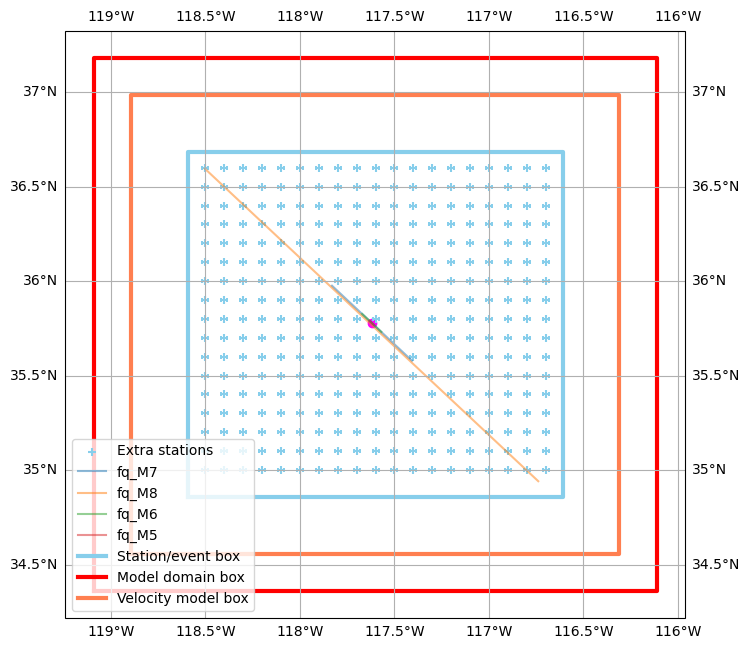

In [48]:
# Find fault extent for each one

fig = plt.figure(figsize = (8, 8))
ax = plt.axes(projection = ccrs.PlateCarree())

plt.scatter(hypocenter[0], hypocenter[1], color = 'magenta')
plt.scatter(extra_sta_lons, extra_sta_lats, marker = '+', color = 'skyblue', label = 'Extra stations')

for idx in range(len(rupts_list)):
    
    rupt = np.genfromtxt(path + rupts_list[idx])
    sf_lons = rupt[:,1]
    sf_lats = rupt[:,2]

    # Fault extent
    min_lon = min(sf_lons)
    max_lon = max(sf_lons)
    min_lat = min(sf_lats)
    max_lat = max(sf_lats)
    
    plt.plot([min_lon, max_lon], [max_lat, min_lat], color = 'C' + str(idx), label = rupts_list[idx][:5], alpha = 0.5)    
        
ax.plot(x_evtsta, y_evtsta, color = 'skyblue', lw = 3, label = 'Station/event box')
ax.plot(x_model_domain, y_model_domain, color = 'red', lw = 3, label = 'Model domain box')
ax.plot(x_vmod, y_vmod, color = 'coral', lw = 3, label = 'Velocity model box')
ax.legend(loc = 'lower left')
ax.coastlines()
gl = ax.gridlines(draw_labels = True)
Plotlims = ax.get_extent()
plt.show()

# Grid Spacing Math

In [49]:
# This is the relationship from the sw4 manual section 4.5, p 28
# npts should be between 6 and 10

def get_step_size(frequency_max, npts, Vs_min):
    H = Vs_min * 1000 / (npts * frequency_max)
    return H
    
step_size = get_step_size(freqMax, 10, vs_min)
print(f"Model grid spacing is {step_size} m ")

Model grid spacing is 810.0000000000001 m 


Based on the grid spacing, we can now compute the thickeness of the supergrid layer. The supergrid layers are SUPER important because they help damp reflections on the edges of the domain and dramatically decreases the size of the domain you need and decreases computational time. The supergrid points are PART of your model domain. Default number of supergrid points is 30, less than 20 points will make your solution numerically unstable. Long wavelengths are harder to supress than short wavelengths

In [50]:
npts_supergrid = 30
supergrid_thickness = step_size * npts_supergrid
supergrid_thickness_deg = np.round(kilometer2degrees(supergrid_thickness/1000), 4)
print(f"Do not put event sources or receivers in the outer {supergrid_thickness} m of the domain \nor a buffer of ~{supergrid_thickness_deg} degrees")

Do not put event sources or receivers in the outer 24300.000000000004 m of the domain 
or a buffer of ~0.2185 degrees


The thickness of our supergrid layer is a lot smaller than the domain we are looking at so I think we can run with the values of lats and lons stored in x1 and y1 (the event/station box)

In [51]:
x_model_domain

[-119.09235724999999,
 -116.10988775000011,
 -116.10988775000011,
 -119.09235724999999,
 -119.09235724999999]

In [52]:
y_model_domain

[34.358218, 34.358218, 37.182942000000025, 37.182942000000025, 34.358218]

In [53]:
Plotlims

(-119.24148072499999, -115.96076427500012, 34.2169818, 37.32417820000003)

In [54]:
lon_min = np.min(x_model_domain)
lon_max = np.max(x_model_domain)
lat_min = np.min(y_model_domain)
lat_max = np.max(y_model_domain)

# Setup points for box for model domain from above
x_sgrid = [x_model_domain[0]+supergrid_thickness_deg, x_model_domain[1]-supergrid_thickness_deg, x_model_domain[2]-supergrid_thickness_deg, x_model_domain[3]+supergrid_thickness_deg, x_model_domain[4]+supergrid_thickness_deg]
y_sgrid = [y_model_domain[0]+supergrid_thickness_deg, y_model_domain[1]+supergrid_thickness_deg, y_model_domain[2]-supergrid_thickness_deg, y_model_domain[3]-supergrid_thickness_deg, y_model_domain[4]+supergrid_thickness_deg]


# Plot with supergrid (and topography if I was including that - deleted some cells)

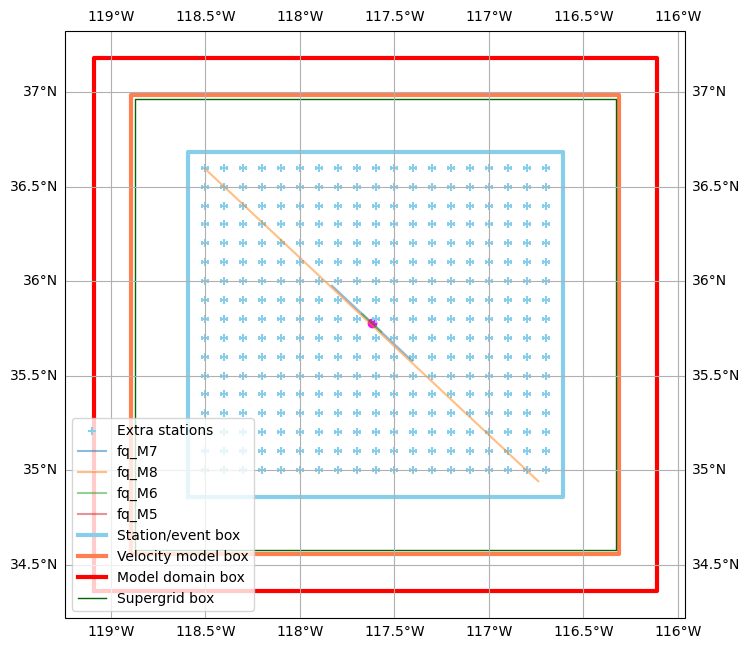

In [55]:
# Find fault extent for each one

fig = plt.figure(figsize = (8, 8))
ax = plt.axes(projection = ccrs.PlateCarree())

plt.scatter(hypocenter[0], hypocenter[1], color = 'magenta')
plt.scatter(extra_sta_lons, extra_sta_lats, marker = '+', color = 'skyblue', label = 'Extra stations')

for idx in range(len(rupts_list)):
    
    rupt = np.genfromtxt(path + rupts_list[idx])
    sf_lons = rupt[:,1]
    sf_lats = rupt[:,2]

    # Fault extent
    min_lon = min(sf_lons)
    max_lon = max(sf_lons)
    min_lat = min(sf_lats)
    max_lat = max(sf_lats)
    
    plt.plot([min_lon, max_lon], [max_lat, min_lat], color = 'C' + str(idx), label = rupts_list[idx][:5], alpha = 0.5)    
        
ax.plot(x_evtsta, y_evtsta, color = 'skyblue', lw = 3, label = 'Station/event box')
ax.plot(x_vmod, y_vmod, color = 'coral', lw = 3, label = 'Velocity model box')
ax.plot(x_model_domain, y_model_domain, color = 'red', lw = 3, label = 'Model domain box')
ax.plot(x_sgrid, y_sgrid, color = 'darkgreen', lw = 1, label = 'Supergrid box')
ax.legend(loc = 'lower left')
ax.coastlines()
gl = ax.gridlines(draw_labels = True)
Plotlims = ax.get_extent()
plt.show()

# Aggregate Info for .in Files

### Grid Command info

In [56]:
# Compute cartesian locations for grid
Y,_,_ = gps2dist_azimuth(lat_min, lon_min, lat_min, lon_max)
X,_,_ = gps2dist_azimuth(lat_min, lon_min, lat_max, lon_min)

print('GRID COMMAND')
print(f"Size of grid - x and y in m: {np.round(X,-1), np.round(Y,-1)}")
print(f"Maximum depth (z) from on velocity model in m: {depth_max}")
print(f"Origin - lat lon of lower left corner of model domain: {lat_min:.3f}, {lon_min:.3f}")
print(f"lat lon of upper right corner of model domain: {lat_max:.3f}, {lon_max:.3f}")
print('az = 0 for this project')
print(f"Model grid spacing (h) should be at least {int(step_size)} m for a frequency max of {freqMax} Hz")
print('')

print(f"grid x={int(X)} y={int(Y)} z=1030000 lat={lat_min:.3f} lon={lon_min:.3f} az=0 h={int(step_size)}")

GRID COMMAND
Size of grid - x and y in m: (313420.0, 274360.0)
Maximum depth (z) from on velocity model in m: 1030000
Origin - lat lon of lower left corner of model domain: 34.358, -119.092
lat lon of upper right corner of model domain: 37.183, -116.110
az = 0 for this project
Model grid spacing (h) should be at least 810 m for a frequency max of 0.1 Hz

grid x=313416 y=274362 z=1030000 lat=34.358 lon=-119.092 az=0 h=810


/var/folders/yg/s8qp7lfs59g_tbwsx_wxkdx80000gn/T/ipykernel_81375/3230086842.py:2: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  Y,_,_ = gps2dist_azimuth(lat_min, lon_min, lat_min, lon_max)
/var/folders/yg/s8qp7lfs59g_tbwsx_wxkdx80000gn/T/ipykernel_81375/3230086842.py:3: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  X,_,_ = gps2dist_azimuth(lat_min, lon_min, lat_max, lon_min)


### Receiver Output Command Info

In [57]:
# set output type
out1 = 'strains'
out2 = 'displacement'

In [58]:
extra_sta_names = []
counter = 0
for i in range(len(extra_sta_lons)):
    counter += 1
    name = int(counter)
    extra_sta_names.append('E' + str(name))

extra_stas_array = np.column_stack((np.array(extra_sta_names), np.array(extra_sta_lons), np.array(extra_sta_lats)))
# print(extra_stas_array)

extra_stas = pd.DataFrame(extra_stas_array, columns = ['name', 'lon', 'lat'])
# extra_stas

extra_stas.to_csv('/Users/sydneydybing/SW4/strain/experiments/realistic_eq_sizes/stas.csv', index = False)

In [59]:
for k in range(len(extra_stas)):
    print(f"rec lat={extra_stas['lat'].astype(float)[k]:.3f} lon={extra_stas['lon'].astype(float)[k]:.3f} depth=0 variables={out1} file={extra_stas['name'][k]+'s'} usgsformat=1 sacformat=0 writeEvery=50")
    print(f"rec lat={extra_stas['lat'].astype(float)[k]:.3f} lon={extra_stas['lon'].astype(float)[k]:.3f} depth=0 variables={out2} file={extra_stas['name'][k]+'d'} usgsformat=1 sacformat=0 writeEvery=50")
    

rec lat=35.000 lon=-118.500 depth=0 variables=strains file=E1s usgsformat=1 sacformat=0 writeEvery=50
rec lat=35.000 lon=-118.500 depth=0 variables=displacement file=E1d usgsformat=1 sacformat=0 writeEvery=50
rec lat=35.100 lon=-118.500 depth=0 variables=strains file=E2s usgsformat=1 sacformat=0 writeEvery=50
rec lat=35.100 lon=-118.500 depth=0 variables=displacement file=E2d usgsformat=1 sacformat=0 writeEvery=50
rec lat=35.200 lon=-118.500 depth=0 variables=strains file=E3s usgsformat=1 sacformat=0 writeEvery=50
rec lat=35.200 lon=-118.500 depth=0 variables=displacement file=E3d usgsformat=1 sacformat=0 writeEvery=50
rec lat=35.300 lon=-118.500 depth=0 variables=strains file=E4s usgsformat=1 sacformat=0 writeEvery=50
rec lat=35.300 lon=-118.500 depth=0 variables=displacement file=E4d usgsformat=1 sacformat=0 writeEvery=50
rec lat=35.400 lon=-118.500 depth=0 variables=strains file=E5s usgsformat=1 sacformat=0 writeEvery=50
rec lat=35.400 lon=-118.500 depth=0 variables=displacement fil

### Memory Calculations

Appendix B says roughly 208 bytes/grid point for runs with topography 

BUT "For parallel runs, the memory per grid point will be somewhat higher, because of duplicated
ghost points at the processor boundaries."

In [60]:
grid_pts = (X/step_size) * (Y/step_size) * (depth_max / step_size)
mem_per_point = 208
mem_gb = grid_pts * mem_per_point / 1e9
print(f"Rough approximation of memory is {np.round(mem_gb, 0)} GB for a maximum frequency of {freqMax} Hz")

Rough approximation of memory is 35.0 GB for a maximum frequency of 0.1 Hz


### Maximum Grid spacing

To have 30 super grid points on the outside of the domain and at least 60 actual grid points in domain, you can't have a step size for your grid higher than:

In [61]:
h_max = np.min([X/120, Y/120, depth_max/90])
h_max

2286.35796764003